# 🏙️ Analiza Miasta 15-minutowego - Kraków

## I Etap: Weryfikacja binarna dostępności usług

Analiza oparta o rzeczywistą sieć uliczną (dystans sieciowy, nie euklidesowy).

**Autor:** Analiza GIS dla pracy magisterskiej  
**Wersja:** 2.0 (zoptymalizowana)

---

## 1. Konfiguracja i Import Bibliotek

In [1]:
# Podstawowe importy
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import time as time_module
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja OSMnx
ox.settings.use_cache = True
ox.settings.log_console = False

print("✅ Biblioteki załadowane pomyślnie!")
print(f"   OSMnx version: {ox.__version__}")

✅ Biblioteki załadowane pomyślnie!
   OSMnx version: 2.0.7


/Users/mati/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# PARAMETRY KONFIGURACYJNE - MOŻNA MODYFIKOWAĆ
# ═══════════════════════════════════════════════════════════════════════════════

# Obszar badań
PLACE_NAME = "Kraków, Poland"

# Prędkość chodu pieszego [km/h] - zakres 3-7 km/h
WALKING_SPEED_KPH = 5.0

# Próg czasowy dla miasta 15-minutowego [minuty]
TIME_THRESHOLD_MIN = 15

# Rozdzielczość siatki pomiarowej [metry]
GRID_RESOLUTION_M = 250

# Układ współrzędnych metrycznych (EPSG:2180 - PL-1992)
CRS_METRIC = "EPSG:2180"
CRS_WGS84 = "EPSG:4326"

print(f"📍 Obszar: {PLACE_NAME}")
print(f"🚶 Prędkość chodu: {WALKING_SPEED_KPH} km/h")
print(f"⏱️  Próg czasowy: {TIME_THRESHOLD_MIN} min")
print(f"📏 Rozdzielczość siatki: {GRID_RESOLUTION_M} m")

📍 Obszar: Kraków, Poland
🚶 Prędkość chodu: 5.0 km/h
⏱️  Próg czasowy: 15 min
📏 Rozdzielczość siatki: 250 m


## 2. Definicja Kategorii POI

In [3]:
tags_config = {
    'Zaopatrzenie': {
        'color': '#e74c3c',
        'icon': '🛒',
        'tags': {
            'shop': ['supermarket', 'discount', 'bakery', 'greengrocer', 'convenience', 'chemist'],
            'amenity': ['marketplace', 'parcel_locker']
        }
    },
    'Zdrowie': {
        'color': '#3498db',
        'icon': '🏥',
        'tags': {
            'amenity': ['pharmacy', 'clinic', 'doctors', 'veterinary']
        }
    },
    'Edukacja': {
        'color': '#9b59b6',
        'icon': '🎓',
        'tags': {
            'amenity': ['kindergarten', 'school', 'childcare']
        }
    },
    'Rekreacja': {
        'color': '#2ecc71',
        'icon': '🌳',
        'tags': {
            'leisure': ['park', 'playground', 'fitness_centre', 'fitness_station', 'pitch', 'dog_park', 'sports_centre'],
            'landuse': ['village_green', 'recreation_ground'],
            'sport': ['fitness', 'soccer', 'swimming'],
            'amenity': ['cafe', 'restaurant', 'pub', 'library', 'community_centre']
        }
    },
    'Transport': {
        'color': '#f39c12',
        'icon': '🚋',
        'tags': {
            'railway': ['tram_stop', 'station', 'halt'],
            'highway': ['bus_stop']
        }
    }
}

print("📋 Zdefiniowane kategorie POI:")
for cat_name, cat_data in tags_config.items():
    tag_count = sum(len(v) for v in cat_data['tags'].values())
    print(f"   {cat_data['icon']} {cat_name}: {tag_count} typów obiektów")

📋 Zdefiniowane kategorie POI:
   🛒 Zaopatrzenie: 8 typów obiektów
   🏥 Zdrowie: 4 typów obiektów
   🎓 Edukacja: 3 typów obiektów
   🌳 Rekreacja: 17 typów obiektów
   🚋 Transport: 4 typów obiektów


## 3. Pobranie Sieci Ulicznej

In [4]:
print(f"🗺️  Pobieranie sieci pieszej dla: {PLACE_NAME}")
print("   (To może potrwać kilka minut...)")

start_time = time_module.time()
G = ox.graph_from_place(PLACE_NAME, network_type='walk')
elapsed = time_module.time() - start_time

print(f"✅ Graf pobrany w {elapsed:.1f}s!")
print(f"   Węzły (nodes): {G.number_of_nodes():,}")
print(f"   Krawędzie (edges): {G.number_of_edges():,}")

🗺️  Pobieranie sieci pieszej dla: Kraków, Poland
   (To może potrwać kilka minut...)
✅ Graf pobrany w 54.2s!
   Węzły (nodes): 145,213
   Krawędzie (edges): 369,590


In [5]:
# Projekcja grafu do układu metrycznego
print(f"🔄 Projekcja grafu do układu: {CRS_METRIC}")
G_proj = ox.project_graph(G, to_crs=CRS_METRIC)

# Obliczenie czasu przejścia dla każdej krawędzi
walking_speed_mpm = WALKING_SPEED_KPH * 1000 / 60  # metry na minutę

print(f"⏱️  Obliczanie czasów przejścia (prędkość: {WALKING_SPEED_KPH} km/h)")

for u, v, data in G_proj.edges(data=True):
    length = data.get('length', 0)
    data['time'] = length / walking_speed_mpm

print("✅ Czasy przejścia obliczone!")

🔄 Projekcja grafu do układu: EPSG:2180
⏱️  Obliczanie czasów przejścia (prędkość: 5.0 km/h)
✅ Czasy przejścia obliczone!


## 4. Pobranie POI

In [6]:
def poi_to_points(gdf):
    """Konwertuje poligony na centroidy."""
    if gdf.empty:
        return gdf
    gdf = gdf.copy()
    new_geoms = []
    for geom in gdf.geometry:
        if geom is None:
            new_geoms.append(None)
        elif geom.geom_type == 'Point':
            new_geoms.append(geom)
        else:
            new_geoms.append(geom.centroid)
    gdf['geometry'] = new_geoms
    return gdf[gdf.geometry.notna()]

# Pobieranie POI
poi_data = {}
print("📍 Pobieranie POI z OpenStreetMap...\n")

for category_name, category_config in tags_config.items():
    print(f"{category_config['icon']} {category_name}...", end=' ')
    try:
        gdf = ox.features_from_place(PLACE_NAME, tags=category_config['tags'])
        if not gdf.empty:
            gdf_points = poi_to_points(gdf).to_crs(CRS_METRIC)
            poi_data[category_name] = gdf_points
            print(f"✅ {len(gdf_points):,} obiektów")
        else:
            poi_data[category_name] = gpd.GeoDataFrame()
            print("⚠️ Brak")
    except Exception as e:
        print(f"❌ {str(e)[:30]}")
        poi_data[category_name] = gpd.GeoDataFrame()

print(f"\n📊 Razem POI: {sum(len(g) for g in poi_data.values()):,}")

📍 Pobieranie POI z OpenStreetMap...

🛒 Zaopatrzenie... ✅ 3,045 obiektów
🏥 Zdrowie... ✅ 708 obiektów
🎓 Edukacja... ✅ 739 obiektów
🌳 Rekreacja... ✅ 4,599 obiektów
🚋 Transport... ✅ 2,319 obiektów

📊 Razem POI: 11,410


## 5. Tworzenie Siatki Pomiarowej

In [7]:
# Granica miasta
print("🗺️  Pobieranie granicy miasta...")
boundary_gdf = ox.geocode_to_gdf(PLACE_NAME).to_crs(CRS_METRIC)
boundary = boundary_gdf.geometry.iloc[0]
print(f"   Powierzchnia: {boundary.area / 1e6:.1f} km²")

# Generowanie siatki
print(f"📏 Generowanie siatki ({GRID_RESOLUTION_M}m)...")
minx, miny, maxx, maxy = boundary.bounds
x_coords = np.arange(minx, maxx, GRID_RESOLUTION_M)
y_coords = np.arange(miny, maxy, GRID_RESOLUTION_M)

points = [Point(x, y) for x in x_coords for y in y_coords if boundary.contains(Point(x, y))]
grid_gdf = gpd.GeoDataFrame({'grid_id': range(len(points))}, geometry=points, crs=CRS_METRIC)

print(f"✅ Siatka: {len(grid_gdf):,} punktów")

# Przypisanie do sieci
print("🔗 Przypisywanie do sieci ulicznej...")
grid_coords = np.array([[pt.x, pt.y] for pt in grid_gdf.geometry])
grid_gdf['nearest_node'] = ox.nearest_nodes(G_proj, grid_coords[:, 0], grid_coords[:, 1])
print(f"   Unikalne węzły: {grid_gdf['nearest_node'].nunique():,}")

🗺️  Pobieranie granicy miasta...
   Powierzchnia: 326.4 km²
📏 Generowanie siatki (250m)...
✅ Siatka: 5,222 punktów
🔗 Przypisywanie do sieci ulicznej...
   Unikalne węzły: 4,774


## 6. Obliczenie Dostępności (ZOPTYMALIZOWANE) ⚡

In [11]:
def calculate_accessibility_fast(G_proj, poi_gdf, grid_gdf, time_threshold):
    """
    ZOPTYMALIZOWANY algorytm obliczania dostępności.
    
    Zamiast liczyć ścieżki od każdego punktu siatki do każdego POI (O(n*m)),
    używamy ODWRÓCONEGO grafu i multi-source Dijkstra od wszystkich POI naraz.
    
    Złożoność: O(E log V) zamiast O(n * m * E log V)
    Przyspieszenie: ~100-1000x
    """
    if poi_gdf.empty:
        return pd.Series(np.inf, index=grid_gdf.index)
    
    # 1. Znajdź węzły z POI
    poi_coords = np.array([[pt.x, pt.y] for pt in poi_gdf.geometry if pt is not None])
    if len(poi_coords) == 0:
        return pd.Series(np.inf, index=grid_gdf.index)
    
    poi_nodes = set(ox.nearest_nodes(G_proj, poi_coords[:, 0], poi_coords[:, 1]))
    
    # 2. Odwróć graf (żeby liczyć DO POI zamiast OD POI)
    G_reversed = G_proj.reverse(copy=True)
    
    # 3. Multi-source Dijkstra od wszystkich POI naraz
    # To oblicza najkrótsze ścieżki od wszystkich POI do wszystkich węzłów w jednym przebiegu!
    distances = nx.multi_source_dijkstra_path_length(
        G_reversed, 
        sources=poi_nodes, 
        weight='time',
        cutoff=time_threshold * 1.5  # mały margines
    )
    
    # 4. Mapuj wyniki na siatkę
    times = grid_gdf['nearest_node'].map(distances).fillna(np.inf)
    
    return times

print("⚡ Funkcja zoptymalizowana zdefiniowana!")
print("   Używa multi-source Dijkstra - ~100x szybciej")

⚡ Funkcja zoptymalizowana zdefiniowana!
   Używa multi-source Dijkstra - ~100x szybciej


In [12]:
# Obliczanie dostępności dla każdej kategorii
print("🔍 Obliczanie dostępności...\n")
print(f"   Próg: {TIME_THRESHOLD_MIN} min | Punktów: {len(grid_gdf):,}")
print("=" * 60)

poi_nodes_by_category = {}

for category_name, gdf_poi in poi_data.items():
    icon = tags_config[category_name]['icon']
    print(f"\n{icon} {category_name}...", end=' ')
    
    start_time = time_module.time()
    
    # Oblicz czasy (SZYBKO!)
    times = calculate_accessibility_fast(G_proj, gdf_poi, grid_gdf, TIME_THRESHOLD_MIN)
    
    elapsed = time_module.time() - start_time
    
    # Zapisz wyniki
    grid_gdf[f'time_{category_name}'] = times
    grid_gdf[f'access_{category_name}'] = (times <= TIME_THRESHOLD_MIN).astype(int)
    
    # Statystyki
    accessible_pct = grid_gdf[f'access_{category_name}'].mean() * 100
    avg_time = times.replace(np.inf, np.nan).mean()
    
    print(f"✅ {elapsed:.1f}s | Dostępność: {accessible_pct:.1f}% | Śr. czas: {avg_time:.1f} min")

print("\n" + "=" * 60)
print("✅ Wszystkie kategorie obliczone!")

🔍 Obliczanie dostępności...

   Próg: 15 min | Punktów: 5,222

🛒 Zaopatrzenie... ✅ 6.5s | Dostępność: 74.4% | Śr. czas: 8.1 min

🏥 Zdrowie... ✅ 6.0s | Dostępność: 49.1% | Śr. czas: 9.3 min

🎓 Edukacja... ✅ 6.6s | Dostępność: 60.8% | Śr. czas: 9.8 min

🌳 Rekreacja... ✅ 5.5s | Dostępność: 85.7% | Śr. czas: 7.0 min

🚋 Transport... ✅ 5.9s | Dostępność: 94.6% | Śr. czas: 5.5 min

✅ Wszystkie kategorie obliczone!


## 7. Compliance Score (Wynik Końcowy)

In [14]:
# Oblicz Compliance Score (0-5)
access_columns = [col for col in grid_gdf.columns if col.startswith('access_')]
grid_gdf['compliance_score'] = grid_gdf[access_columns].sum(axis=1)

print("📊 COMPLIANCE SCORE - PODSUMOWANIE")
print("=" * 50)

labels = {
    0: "Brak dostępu",
    1: "1 kategoria",
    2: "2 kategorie",
    3: "3 kategorie",
    4: "4 kategorie",
    5: "✅ Pełne miasto 15-min"
}

score_dist = grid_gdf['compliance_score'].value_counts().sort_index()

for score in range(6):
    count = score_dist.get(score, 0)
    pct = count / len(grid_gdf) * 100
    bar = "█" * int(pct / 2)
    print(f"   {score}: {bar} {pct:.1f}% ({count:,}) - {labels[score]}")

print(f"\n   📈 Średni wynik: {grid_gdf['compliance_score'].mean():.2f} / 5")
print(f"   📊 Mediana: {grid_gdf['compliance_score'].median():.0f} / 5")

📊 COMPLIANCE SCORE - PODSUMOWANIE
   0: █ 3.7% (191) - Brak dostępu
   1: ███ 7.4% (385) - 1 kategoria
   2: ███████ 14.4% (753) - 2 kategorie
   3: ██████ 14.0% (730) - 3 kategorie
   4: ████████ 16.4% (858) - 4 kategorie
   5: ██████████████████████ 44.1% (2,305) - ✅ Pełne miasto 15-min

   📈 Średni wynik: 3.65 / 5
   📊 Mediana: 4 / 5


## 8. Wizualizacja - Mapa Compliance Score

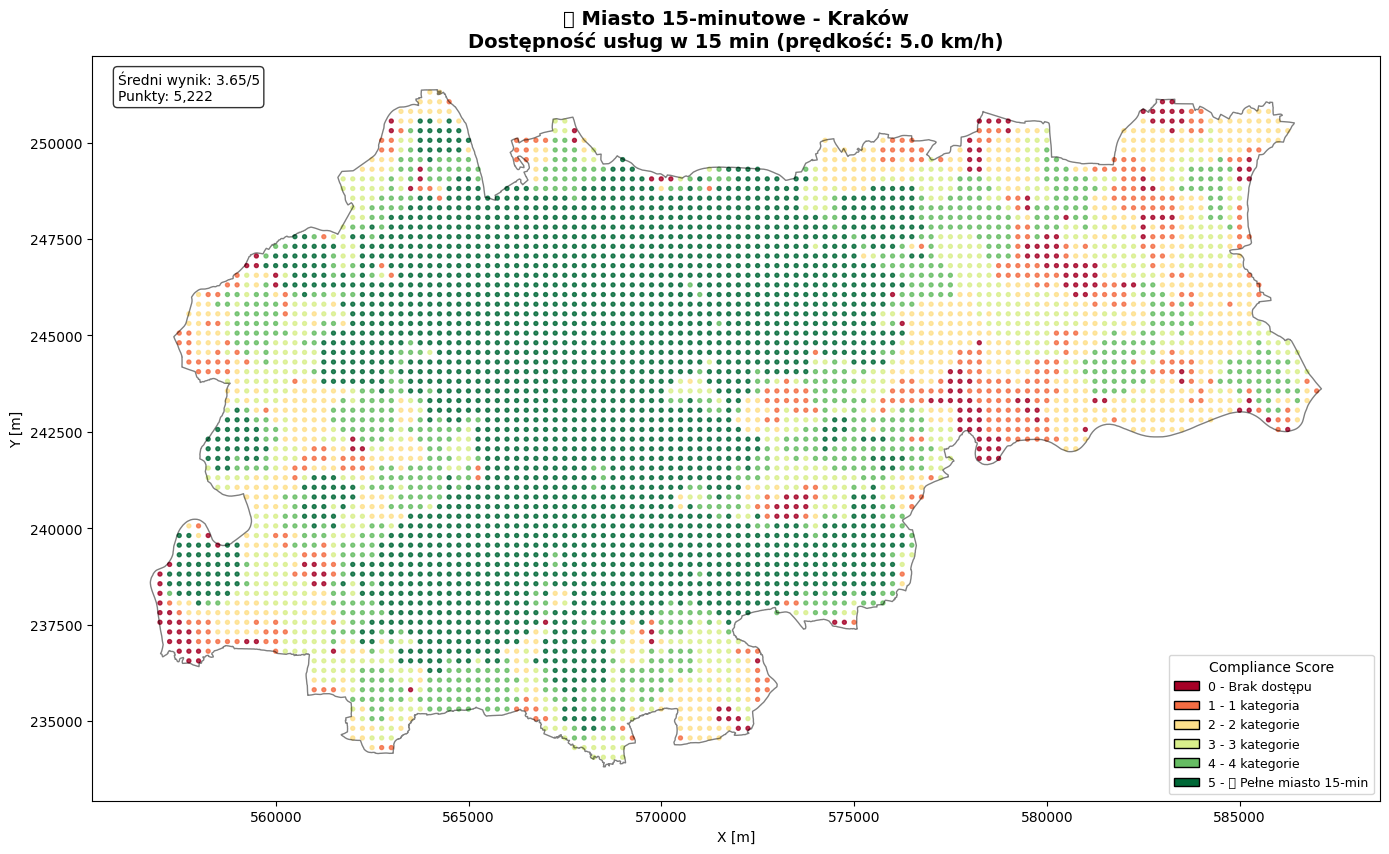

💾 Zapisano: data/mapa_compliance_score.png


In [15]:
# Mapa Compliance Score
cmap_compliance = plt.cm.RdYlGn
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = BoundaryNorm(bounds, cmap_compliance.N)

fig, ax = plt.subplots(figsize=(14, 12))

boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.5)
grid_gdf.plot(ax=ax, column='compliance_score', cmap=cmap_compliance, norm=norm, markersize=8, alpha=0.8)

legend_elements = [
    mpatches.Patch(facecolor=cmap_compliance(norm(i)), edgecolor='black', label=f'{i} - {labels[i]}')
    for i in range(6)
]
ax.legend(handles=legend_elements, loc='lower right', title='Compliance Score', fontsize=9)

ax.set_title(
    f'🏙️ Miasto 15-minutowe - Kraków\n'
    f'Dostępność usług w {TIME_THRESHOLD_MIN} min (prędkość: {WALKING_SPEED_KPH} km/h)',
    fontsize=14, fontweight='bold'
)
ax.set_aspect('equal')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

stats_text = f"Średni wynik: {grid_gdf['compliance_score'].mean():.2f}/5\nPunkty: {len(grid_gdf):,}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('data/mapa_compliance_score.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/mapa_compliance_score.png")

## 9. Wizualizacja - Mapy Walkability per Kategoria

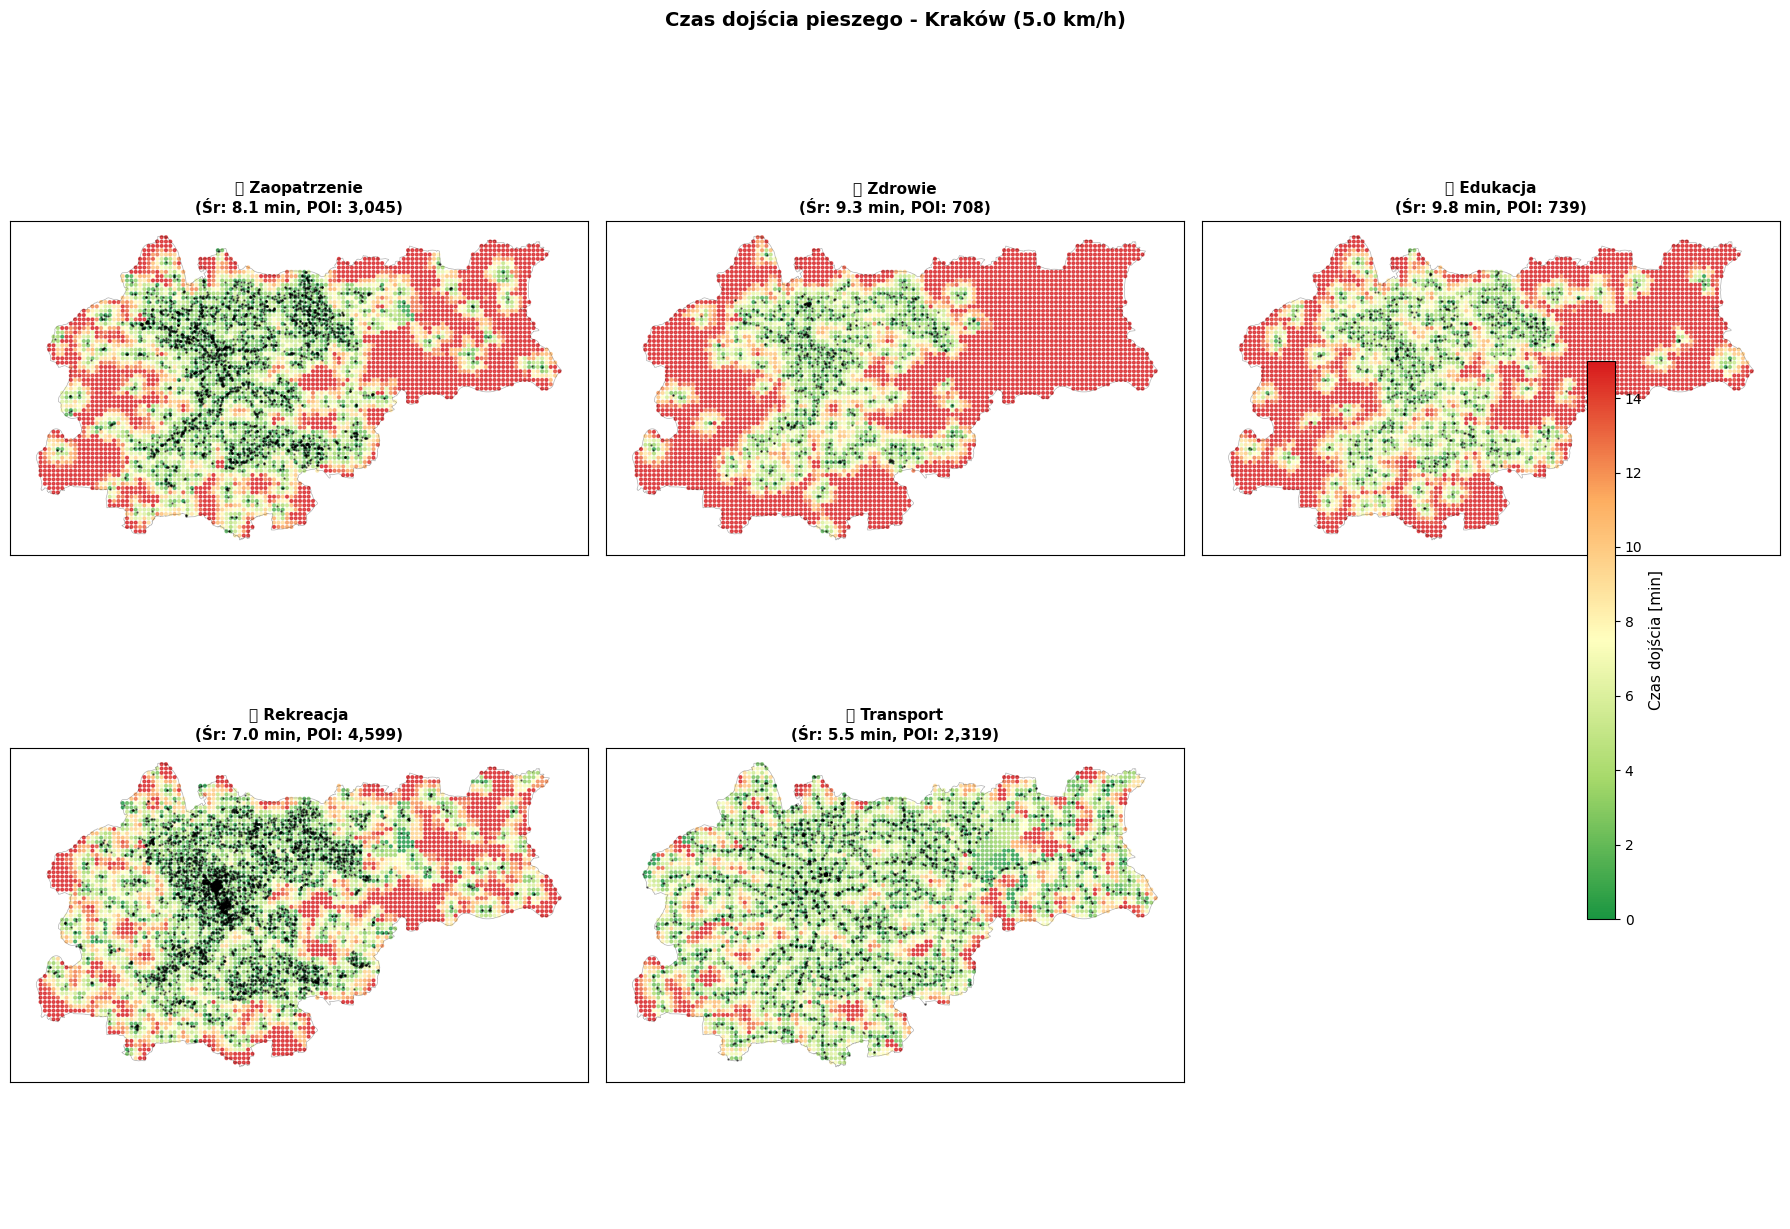

💾 Zapisano: data/mapy_walkability_kategorie.png


In [16]:
# Mapa czasów dojścia per kategoria
colors_walk = ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']
cmap_walk = LinearSegmentedColormap.from_list('walk', colors_walk)

n_cat = len(poi_data)
n_cols = 3
n_rows = (n_cat + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for idx, (cat_name, gdf_poi) in enumerate(poi_data.items()):
    ax = axes[idx]
    time_col = f'time_{cat_name}'
    icon = tags_config[cat_name]['icon']
    
    plot_data = grid_gdf.copy()
    plot_data[time_col] = plot_data[time_col].clip(upper=TIME_THRESHOLD_MIN)
    
    boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.3)
    plot_data.plot(ax=ax, column=time_col, cmap=cmap_walk, vmin=0, vmax=TIME_THRESHOLD_MIN, markersize=4, alpha=0.7)
    
    if not gdf_poi.empty:
        gdf_poi.plot(ax=ax, color='black', markersize=2, alpha=0.5, marker='.')
    
    avg_time = grid_gdf[time_col].replace(np.inf, np.nan).mean()
    poi_count = len(gdf_poi) if not gdf_poi.empty else 0
    
    ax.set_title(f'{icon} {cat_name}\n(Śr: {avg_time:.1f} min, POI: {poi_count:,})', fontsize=11, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

for idx in range(n_cat, len(axes)):
    axes[idx].axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap_walk, norm=plt.Normalize(vmin=0, vmax=TIME_THRESHOLD_MIN))
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Czas dojścia [min]', fontsize=11)

fig.suptitle(f'Czas dojścia pieszego - Kraków ({WALKING_SPEED_KPH} km/h)', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('data/mapy_walkability_kategorie.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/mapy_walkability_kategorie.png")

## 10. Eksport Wyników

In [17]:
# Eksport do GeoPackage
output_file = 'data/miasto_15_min_wyniki.gpkg'
export_gdf = grid_gdf.copy().to_crs(CRS_WGS84)
export_gdf.to_file(output_file, driver='GPKG', layer='accessibility_grid')
print(f"💾 GeoPackage: {output_file}")

# Statystyki CSV
stats_data = []
for cat in tags_config.keys():
    time_col = f'time_{cat}'
    access_col = f'access_{cat}'
    stats_data.append({
        'Kategoria': cat,
        'POI': len(poi_data.get(cat, [])),
        'Sredni_czas_min': round(grid_gdf[time_col].replace(np.inf, np.nan).mean(), 2),
        'Dostepnosc_pct': round(grid_gdf[access_col].mean() * 100, 1)
    })

pd.DataFrame(stats_data).to_csv('data/statystyki_dostepnosci.csv', index=False, encoding='utf-8-sig')
print("💾 CSV: data/statystyki_dostepnosci.csv")

print("\n✅ ANALIZA ZAKOŃCZONA!")

💾 GeoPackage: data/miasto_15_min_wyniki.gpkg
💾 CSV: data/statystyki_dostepnosci.csv

✅ ANALIZA ZAKOŃCZONA!
